In [1]:
import numpy as np
import scipy as sp
import bordado as bd
import matplotlib.pyplot as plt
import ipywidgets

In [2]:
def modelagem_direta(x, y, xs, ys, vp, vs):
    return (
        np.sqrt((x - xs)**2 + (y - ys)**2) * (1/vs - 1/vp)
    )

In [108]:
def mapa_objetivo(xs, ys, vp, vs, tempo):
    x, y = bd.grid_coordinates(region, spacing=5e3)
    predito = modelagem_direta(x, y, xs[:, np.newaxis, np.newaxis], ys[:, np.newaxis, np.newaxis], vp, vs)
    objetivo = np.linalg.norm(tempo[:, np.newaxis, np.newaxis] - predito, axis=0)**2
    plt.contourf(x, y, objetivo, 40, cmap="gray")

[ 90.60289868  89.44370234 113.13749887  94.65693597]


(0.0, 500000.0)

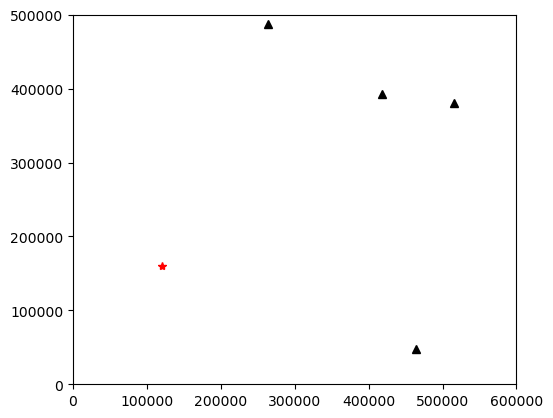

In [109]:
region = (0, 600e3, 0, 500e3)
xs, ys = bd.random_coordinates(region, size=4, random_seed=42)
x_true, y_true = 120e3, 160e3
vp = 4000
vs = 2000
tempo = modelagem_direta(x_true, y_true, xs, ys, vp, vs)
print(tempo)

plt.plot(xs, ys, "^k")
plt.plot(x_true, y_true, "*r")
plt.axis("scaled")
plt.xlim(*region[:2])
plt.ylim(*region[2:])

In [110]:
def jacobiana(x, y, xs, ys, vp, vs):
    A = np.empty((xs.size, 2))
    distancia = np.sqrt((x - xs)**2 + (y - ys)**2)
    fator = (1/vs - 1/vp)
    A[:, 0] = (x - xs) * fator / distancia
    A[:, 1] = (y - ys) * fator / distancia
    return A

In [173]:
def epicentro_newton(xi, yi, xs, ys, vp, vs, tempo, maxit=50, tol=1e-3):
    x, y = xi, yi
    residuos = tempo - modelagem_direta(x, y, xs, ys, vp, vs)
    x_iterações = [x]
    y_iterações = [y]
    objetivo = [np.linalg.norm(residuos)**2]
    for i in range(maxit):
        A = jacobiana(x, y, xs, ys, vp, vs)
        x_passo, y_passo = sp.linalg.solve(A.T @ A, A.T @ residuos)
        x = x + x_passo
        y = y + y_passo
        residuos = tempo - modelagem_direta(x, y, xs, ys, vp, vs)
        objetivo.append(np.linalg.norm(residuos)**2)
        x_iterações.append(x)
        y_iterações.append(y)
        if abs(objetivo[-1] - objetivo[-2]) / objetivo[0] <= tol:
            break
    return x_iterações, y_iterações, objetivo        

def epicentro_levmarq(xi, yi, xs, ys, vp, vs, tempo, maxit=50, tol=1e-3, alpha=10, dalpha=10):
    x, y = xi, yi
    residuos = tempo - modelagem_direta(x, y, xs, ys, vp, vs)
    x_iterações = [x]
    y_iterações = [y]
    objetivo = [np.linalg.norm(residuos)**2]
    I = np.eye(2)
    for i in range(maxit):
        A = jacobiana(x, y, xs, ys, vp, vs)
        H = A.T @ A
        P = np.diag(1 / np.abs(np.diagonal(H)))
        H = P @ H    
        gradiente = P @ A.T @ residuos
        stagnate = True
        for j in range(20):             
            x_passo, y_passo = sp.linalg.solve(H + alpha * I, gradiente)            
            residuos = tempo - modelagem_direta(x + x_passo, y + y_passo, xs, ys, vp, vs)
            nova_objetivo = np.linalg.norm(residuos)**2
            if nova_objetivo > objetivo[-1]:
                alpha *= dalpha
            else:
                alpha /= dalpha
                stagnate = False
                break
        if not stagnate:
            x = x + x_passo
            y = y + y_passo
            objetivo.append(nova_objetivo)
            x_iterações.append(x)
            y_iterações.append(y)
        else:
            break
        if abs(objetivo[-1] - objetivo[-2]) / objetivo[0] <= tol:
            break
    return x_iterações, y_iterações, objetivo        

In [174]:
xis, yis = bd.random_coordinates(region, size=6, random_seed=0)
soluções_newton = []
soluções_levmarq = []
for xi, yi in zip(xis, yis):
    x_it, y_it, objetivo = epicentro_newton(xi, yi, xs, ys, vp, vs, tempo)
    soluções_newton.append((x_it, y_it))
    x_it, y_it, objetivo = epicentro_levmarq(xi, yi, xs, ys, vp, vs, tempo)
    soluções_levmarq.append((x_it, y_it))

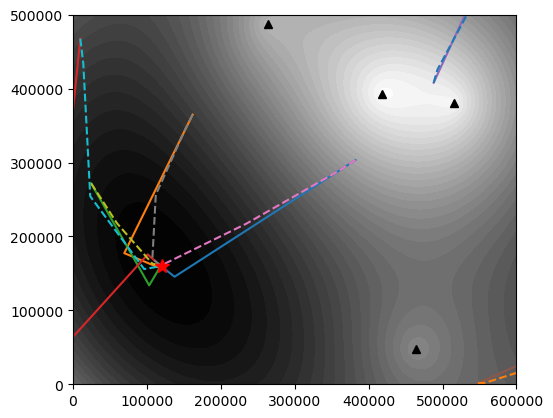

In [176]:
plt.plot(xs, ys, "^k")
for x_it, y_it in soluções_newton:
    plt.plot(x_it, y_it, "-")
for x_it, y_it in soluções_levmarq:
    plt.plot(x_it, y_it, "--")
plt.plot(x_true, y_true, "*r", markersize=10)
plt.axis("scaled")
plt.xlim(*region[:2])
plt.ylim(*region[2:])
mapa_objetivo(xs, ys, vp, vs, tempo)